In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/Car Plate Dataset/Persian_OCR_Dataset_Medium.zip'

unzip_dir = '/content/Final'  # Define the output directory

os.makedirs(unzip_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f'Files successfully unzipped to {unzip_dir}')


Files successfully unzipped to /content/Final


In [5]:
import os
from pathlib import Path

data_dir = Path("/content/Final/Persian_OCR_Dataset_Medium")

if data_dir.exists():
    print("Directory exists")
    print("Contents:")
    print(list(data_dir.iterdir())[:10])  # Print first 10 files
else:
    print("Directory does not exist")

# Include .jpg, .jpeg, and .png file formats
images = sorted(list(map(str, list(data_dir.glob("*.jpg")) +
                                list(data_dir.glob("*.jpeg")) +
                                list(data_dir.glob("*.png")))))

# Filter out images with filenames having less than 8 characters before the extension
to_remove = [img for img in images if len(Path(img).stem) < 8]

# Delete the filtered images
for img_path in to_remove:
    os.remove(img_path)
    print(f"Removed: {img_path}")

# Update the images list after removal
images = sorted(list(map(str, list(data_dir.glob("*.jpg")) +
                                list(data_dir.glob("*.jpeg")) +
                                list(data_dir.glob("*.png")))))

# Extract labels from image filenames
labels = [img.split(os.path.sep)[-1].split(".")[0].split("_")[0] for img in images]

print("Number of images found after removal: ", len(images))
print("Number of labels found: ", len(labels))

Directory exists
Contents:
[PosixPath('/content/Final/Persian_OCR_Dataset_Medium/30@71989.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/16A76436.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/91U89166.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/19A29714.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/93I68431.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/64G45695_80$34.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/24K35927_8903.jpg'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/90@87435.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/98@44345.png'), PosixPath('/content/Final/Persian_OCR_Dataset_Medium/85U77060.png')]
Number of images found after removal:  16750
Number of labels found:  16750


In [6]:
characters = set(char for label in labels for char in label)

characters = sorted(list(characters))

extra_characters = ['-', '@', '&']

characters.extend(extra_characters)
characters = sorted(list(set(characters)))

print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of unique characters:  39
Characters present:  ['&', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [7]:
batch_size = 16
img_width = 256
img_height = 65
downsample_factor = 4
plate_length = len(labels[0])  # Assuming all labels are of the same length
max_length = 8  # Fixed length for labels

In [8]:
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)
print(char_to_num.get_vocabulary())

['[UNK]', '&', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [9]:
train_size = 0.8
images, labels = np.array(images), np.array(labels)
size = len(images)
indices = np.arange(size)
np.random.shuffle(indices)
train_samples = int(size * train_size)
x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

In [10]:
def pad_label(label):
    return label.ljust(max_length)[:max_length]

y_train = [pad_label(label) for label in y_train]
y_valid = [pad_label(label) for label in y_valid]

def encode_single_sample(img_path, label):
    # Read and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    label = tf.pad(label, [[0, max_length - tf.shape(label)[0]]], constant_values=0)  # Padding to max_length

    return img, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

new_shape = (img_width // 16, (img_height // 16) * 256)
nclasses = len(char_to_num.get_vocabulary())

model = keras.models.Sequential([
    layers.Input(shape=(img_width, img_height, 1)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Reshape(target_shape=new_shape),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Conv1D(64, 3, activation="relu", padding="same"),
    layers.MaxPooling1D(2),
    layers.Dropout(0.5),
    layers.Dense(nclasses, activation="softmax")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs = 20
early_stopping_patience = 30
reduce_lr_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=reduce_lr_patience
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)

# Save the model with the best weights
model.save('ocr_best_model.keras')

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.3399 - loss: 2.1616 - val_accuracy: 0.9145 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.8961 - loss: 0.3604 - val_accuracy: 0.9488 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.9310 - loss: 0.2327 - val_accuracy: 0.9690 - val_loss: 0.1187 - learning_rate: 0.0010
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - accuracy: 0.9508 - loss: 0.1652 - val_accuracy: 0.9749 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9620 - loss: 0.1311 - val_accuracy: 0.9799 - val_loss: 0.0804 - learning_rate: 0.0010
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.9678 - loss: 0.1092 - val_accuracy: 0.9814 - val_loss: 0.0776 - learning_rate: 0.0010
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.9732 - l

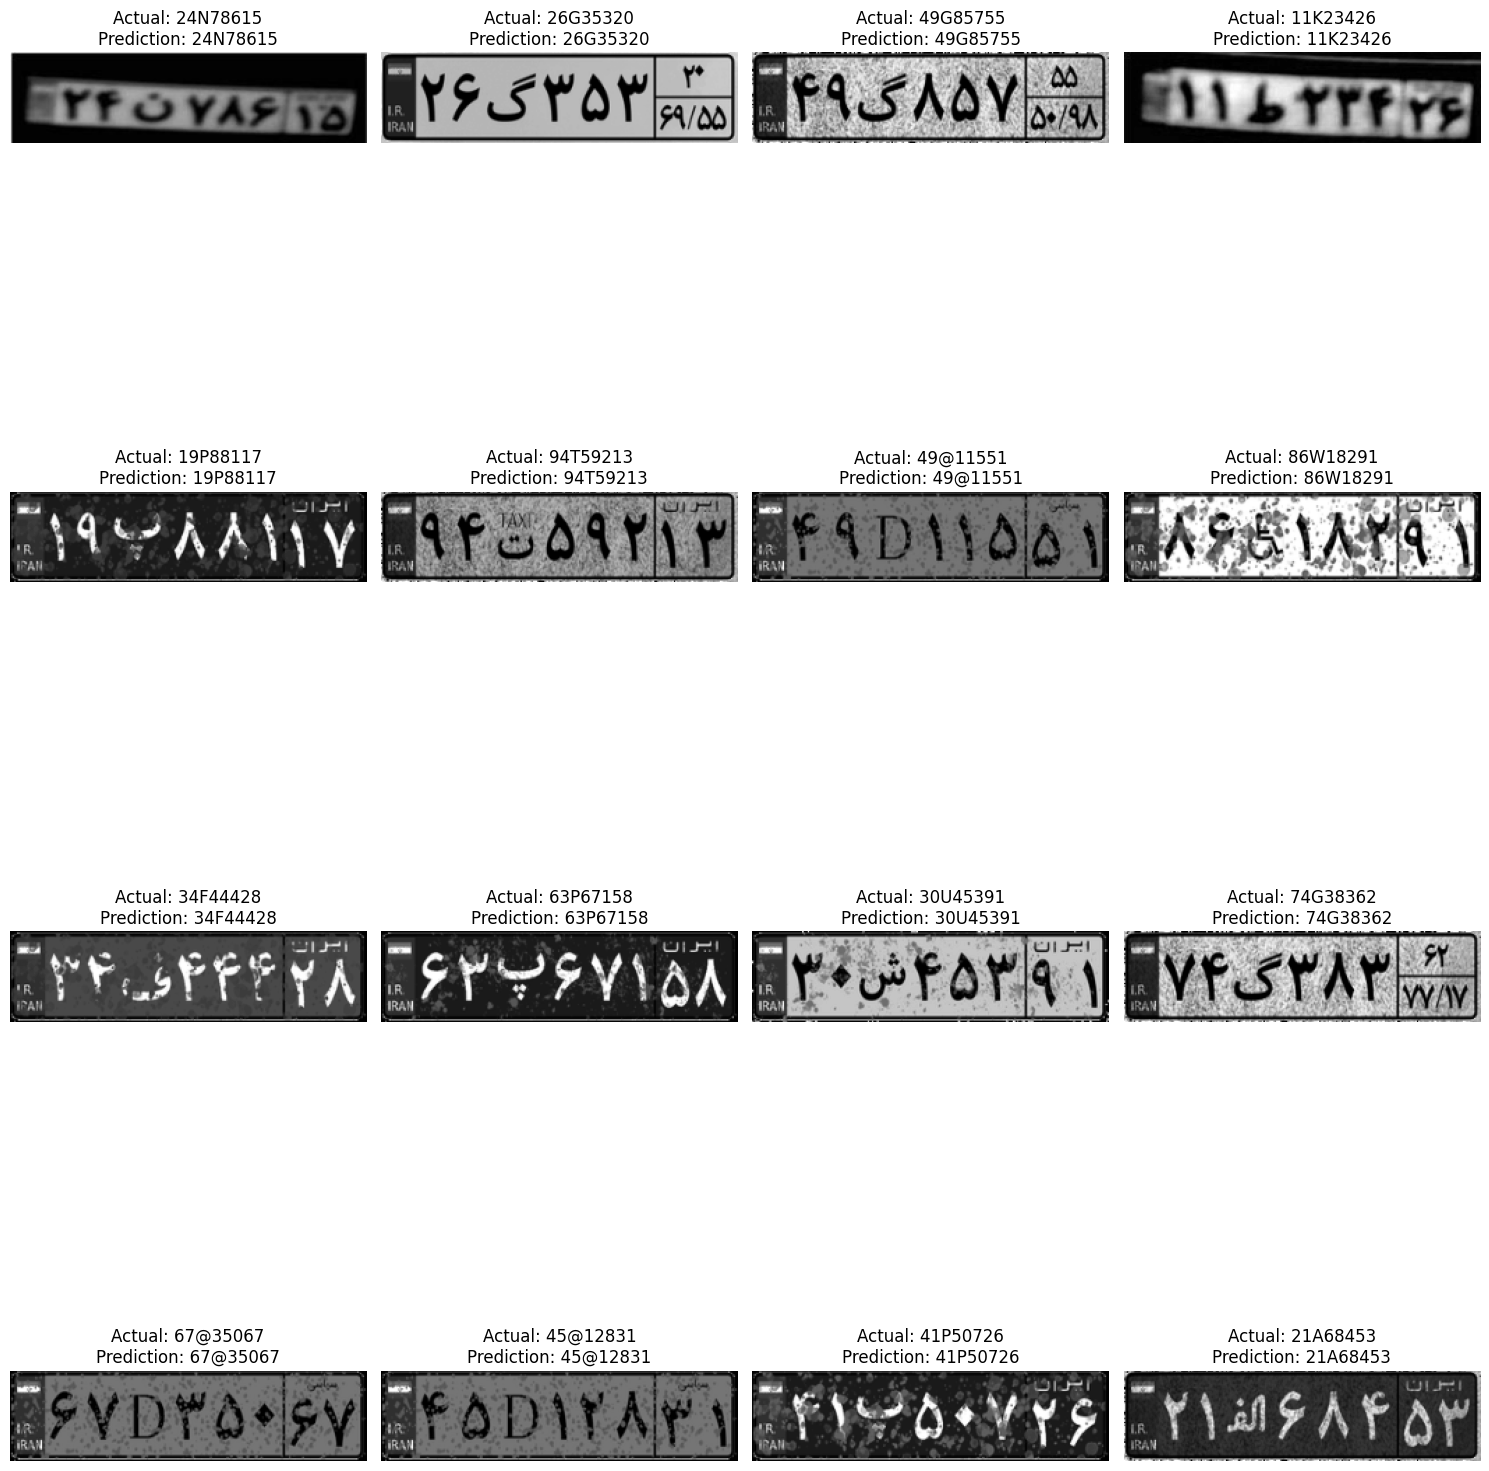

In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get the number of batches in the dataset
num_batches = len(validation_dataset)

# Randomly select a batch
random_batch_idx = random.randint(0, num_batches - 1)

# Iterate through the dataset and select the random batch
for idx, batch in enumerate(validation_dataset):
    if idx == random_batch_idx:
        batch_images = batch[0]
        batch_labels = batch[1]
        break

# Predict and visualize the random batch
preds = model.predict(batch_images, verbose=0)
preds = preds.argmax(axis=-1)

pred_texts = []
for p in preds:
    label = tf.strings.reduce_join(num_to_char(p)).numpy().decode("utf-8")
    pred_texts.append(label)

orig_texts = []
for label in batch_labels:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    orig_texts.append(label)

# Calculate the number of images in the batch
batch_size = len(pred_texts)

# Set the number of rows and columns for the subplots
cols = 4
rows = (batch_size + cols - 1) // cols  # Calculate the number of rows needed

# Plot the images with both predicted and actual labels
fig, ax = plt.subplots(rows, cols, figsize=(15, rows * 5))

# If batch size is less than rows * cols, flatten the axis for easier access
ax = ax.ravel() if rows > 1 else [ax]

for i in range(batch_size):
    img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T
    title = f"Actual: {orig_texts[i]}\nPrediction: {pred_texts[i]}"
    ax[i].imshow(img, cmap="gray")
    ax[i].set_title(title)
    ax[i].axis("off")

# Turn off the remaining axes (if any)
for i in range(batch_size, len(ax)):
    ax[i].axis("off")

plt.tight_layout()
plt.show()

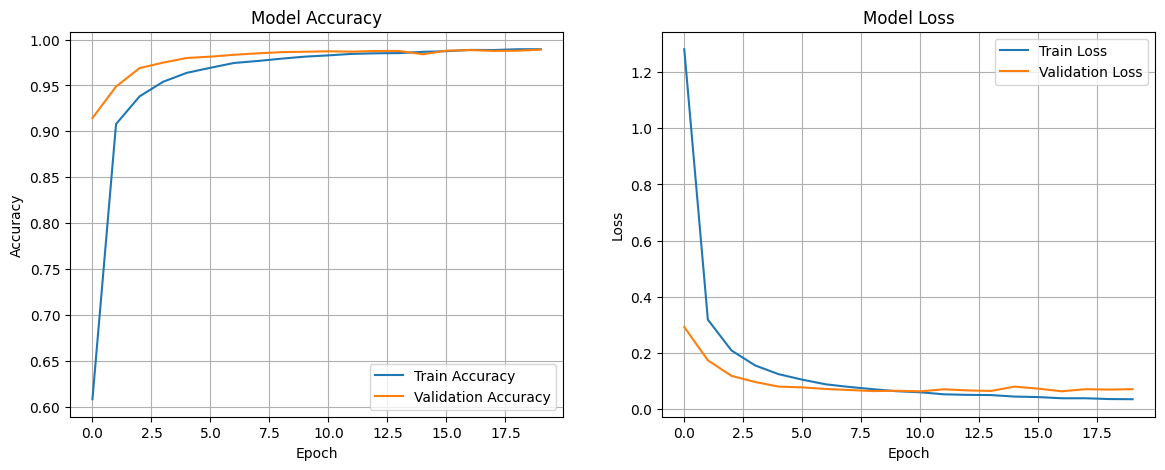

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Step 1: Plot Train and Validation Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Step 2: Plot Train and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [13]:
# Load the model from the specified path
model = keras.models.load_model('/content/ocr_best_model.keras')

# Verify the model is loaded correctly
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 65, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 8, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 4, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 16, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8, 40)               │           2,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,638,842 (6.25 MB)

 Trainable params: 546,280 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,092,562 (4.17 MB)

In [15]:
# Path to the image
image_path = '/content/Final/Persian_OCR_Dataset_Medium/10-63365.png'

# Preprocess the image
img = tf.io.read_file(image_path)
img = tf.io.decode_jpeg(img, channels=1)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [img_height, img_width])
img = tf.transpose(img, perm=[1, 0, 2])
img = tf.expand_dims(img, axis=0)  # Add batch dimension

In [16]:
# Predict
pred = model.predict(img)
pred = pred.argmax(axis=-1)

# Convert prediction back to text
predicted_label = tf.strings.reduce_join(num_to_char(pred)).numpy().decode("utf-8")

# Print the predicted label
print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: 10-63365


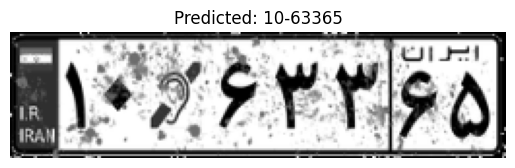

In [17]:
# Convert image for visualization
img_visual = (img.numpy()[0] * 255).astype("uint8")

# Plot the image
plt.imshow(img_visual[:, :, 0].T, cmap="gray")
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()